<a href="https://colab.research.google.com/github/JUICEMAN123/Music-Generation-Variety/blob/main/Music%20Generation%20with%20LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pretty_midi
!pip install np_utils

     |████████████████████████████████| 5.6 MB 4.3 MB/s 
     |████████████████████████████████| 51 kB 9.5 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=5333b33ce02976837ffa8906dd3981e07190025945395c8f385148f50517bd1c
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
     |████████████████████████████████| 61 kB 718 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=d35bd00d408b94050845f656477501bea86ab5173cbc1de5e7f43c54efe200d9
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [3]:
import os
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models
import pretty_midi
from PIL import Image
import matplotlib.pyplot as plt

import time
import logging
import pathlib
from tqdm.autonotebook import tqdm
import pandas as pd
import np_utils

import random

from IPython import display

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  del sys.path[0]


In [4]:
tf.version.VERSION

'2.7.0'

In [5]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

In [6]:
path = '/content/drive/MyDrive/maestro-v3.0.0-midi/maestro-v3.0.0/2018'

os.chdir(path)
midi_paths = []
for fn in os.listdir():
  midi_paths.append(path+'/'+fn)

os.chdir('/content')

In [7]:
new_dir = '/content/drive/MyDrive/maestro_midi_images/'

In [8]:
FS = 10
midi_dims = 127
seq_len = 100

In [9]:
def midi2proll(filename):
  midi_pretty_format = pretty_midi.PrettyMIDI(filename)
  midi_piano = midi_pretty_format.instruments[0]
  midi_piano_roll = midi_piano.get_piano_roll(fs=FS)
  return midi_piano_roll # returns piano roll in format (128 notes, time)

def proll2midi(proll):
  notes, frames = proll.shape
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=0)

  proll = np.pad(proll, [(0, 0), (1, 1)], 'constant')
  velocity_changes = np.nonzero(np.diff(proll).T)

  prev_velocities = np.zeros(notes, dtype=int)
  note_on_time = np.zeros(notes)

  for time, note in zip(*velocity_changes):
      velocity = proll[note, time + 1]
      time = time / FS
      if velocity > 0:
          if prev_velocities[note] == 0:
              note_on_time[note] = time
              prev_velocities[note] = velocity
      else:
          pm_note = pretty_midi.Note(
              velocity=prev_velocities[note],
              pitch=note,
              start=note_on_time[note],
              end=time)
          instrument.notes.append(pm_note)
          prev_velocities[note] = 0
  pm.instruments.append(instrument)
  return pm

def proll2img(proll, show=False):
  im = Image.fromarray(np.uint8(proll))
  if show:
    plt.imshow(np.asarray(im), aspect='auto', cmap='gray')
  return im

def proll2notelist(proll):
  pnotelist = []
  for t, tarr in enumerate(np.transpose(proll)):
    pnotelist.append([])
    for n, val in enumerate(tarr):
      if(val > 0):
        pnotelist[t].append(str(n))          
  return pnotelist

def pnotelist2proll(pnotelist):
  proll = np.zeros((midi_dims, len(pnotelist)))
  for t, notes in enumerate(pnotelist):
    for n in notes:
      proll[n][t] = 1
  return proll

In [10]:
def transform_pnotelist(pnotelist):
  transformed_pnotelist = []
  for notes in pnotelist:
    transformed_pnotelist.append(','.join(notes))
  return np.asarray(transformed_pnotelist)

def untransform_pnotelist(pnotelist):
  untransformed_pnotelist = []
  for t in pnotelist:
    notes = t.split(',')
    tmp = []
    for n in notes:
      if n is not '':
        tmp.append(int(n))
    untransformed_pnotelist.append(tmp)
  return untransformed_pnotelist

def get_musical_corpus(filepaths, show_progress=True):
  all_seq = []
  iter = enumerate(filepaths)
  if(show_progress):
    iter = tqdm(enumerate(filepaths), total=len(filepaths))
  for i, fp in iter:
    all_seq.append(transform_pnotelist(proll2notelist(midi2proll(fp))))
  all_seq = np.asarray(all_seq)
  return all_seq

def transform_musical_corpus(musical_corpus):
  data_in = []
  data_out = []
  for i in range(0, len(musical_corpus) - seq_len, 1):
    sequence_in = musical_corpus[i:i + seq_len]
    sequence_out = musical_corpus[i + seq_len]
    data_in.append(sequence_in)
    data_out.append(sequence_out)
  return (np.asarray(data_in), np.asarray(data_out))

def pad_array(arr, target_length):
  if target_length < np.shape(arr)[0]:
    return arr[:target_length]
  padding = np.full((target_length - np.shape(arr)[0],), '')
  return np.concatenate([arr, padding])

In [11]:
vocab_instances = 8

# first 8 to retrieve vocabulary
musical_corpus = np.concatenate(get_musical_corpus(midi_paths[:vocab_instances]))

FINAL_VOCAB_SIZE = 50000

vocab_size = np.shape(np.unique(musical_corpus))[0]
print('Base Vocab Size', vocab_size)

vec = layers.TextVectorization(max_tokens=FINAL_VOCAB_SIZE + 1, standardize=None, split=None)
vec.adapt(musical_corpus)
vocabulary = vec.get_vocabulary()
vocabulary.remove('[UNK]')
vocab_size = len(vocabulary)

print('Final Vocab Size', len(vocabulary))

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Base Vocab Size 15688
Final Vocab Size 15688


In [12]:
ids_from_chars = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=vocabulary, mask_token=None)
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [13]:
def efficient_get_data_vec(start, end=None):
  if end is None:
    end = start
    start = 0
  musical_corpus = np.concatenate(get_musical_corpus([midi_paths[start]], show_progress=False))
  data_in, data_out = transform_musical_corpus(musical_corpus)
  data_in_vectorized = ids_from_chars(data_in)
  data_out_vectorized = ids_from_chars(data_out)
  del data_in, data_out
  for i in tqdm(range(start+1, end), total=end-start-1):
    musical_corpus = np.concatenate(get_musical_corpus([midi_paths[i]], show_progress=False))
    data_in, data_out = transform_musical_corpus(musical_corpus)
    data_in_vectorized = tf.concat([data_in_vectorized, ids_from_chars(data_in)], axis=0)
    data_out_vectorized = tf.concat([data_out_vectorized, ids_from_chars(data_out)], axis=0)
  del data_in, data_out, musical_corpus
  return (data_in_vectorized, data_out_vectorized)

In [14]:
data_vectorized = efficient_get_data_vec(80)

  0%|          | 0/79 [00:00<?, ?it/s]

In [15]:
data_test_vectorized = efficient_get_data_vec(81, 85)

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
TRAIN_TOTAL_SIZE = len(data_vectorized[0])
TEST_TOTAL_SIZE = len(data_test_vectorized[0])
BATCH_SIZE = 128
N_TRAIN_BATCHES = int(TRAIN_TOTAL_SIZE/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_TOTAL_SIZE/BATCH_SIZE)

print(TRAIN_TOTAL_SIZE)
print(TEST_TOTAL_SIZE)

729237
78381


In [17]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(data_vectorized)
    .cache()
    .shuffle(100000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(data_test_vectorized)
    .cache()
    .shuffle(100000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [18]:
print(train_dataset)
print(test_dataset)

<PrefetchDataset shapes: ((128, 100), (128,)), types: (tf.int64, tf.int64)>
<PrefetchDataset shapes: ((128, 100), (128,)), types: (tf.int64, tf.int64)>


In [19]:
# del data_in, data_out, data_in_vectorized, data_out_vectorized, data_vectorized, train_dataset

# Model

In [20]:
vocab_size = len(ids_from_chars.get_vocabulary())
rnn_units = 512
e_dim = 256
dff = 512
dropout_prop = 0.4
input_shape = (seq_len,)

In [21]:
def MusicGenerator(vocab_size, e_dim, rnn_units, dff, dropout_prop):
  model = tf.keras.Sequential()
  model.add(layers.Embedding(vocab_size, e_dim, input_shape=input_shape))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.LSTM(rnn_units, return_sequences=True))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.LSTM(rnn_units, return_sequences=True))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.LSTM(rnn_units))
  model.add(layers.Dense(dff))
  model.add(layers.Dropout(dropout_prop))
  model.add(layers.Dense(vocab_size))
  model.add(layers.Activation('softmax'))
  return model

In [22]:
model = MusicGenerator(
    vocab_size=vocab_size,
    e_dim=e_dim,
    rnn_units=rnn_units,
    dff=dff,
    dropout_prop=dropout_prop)

In [23]:
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 256)          4016384   
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 512)          1574912   
                                                                 
 dropout_1 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 512)          2099200   
                                                                 
 dropout_2 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2

In [24]:
model.load_weights("/content/drive/MyDrive/rnn-music-midis/models/models_lstm.ckpt")

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(), metrics=[tf.metrics.SparseCategoricalAccuracy()])

# Train Model

**Setup Checkpoints**

In [26]:
!pwd

/content


In [27]:
checkpoint_path = "/content/drive/MyDrive/rnn-music-midis/models/models_lstm.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True)

**Fit Model**

70 epochs completed

other idea - autoencoder:

encoder encodes the sequence

decoder determines which notes are on

In [28]:
EPOCHS = 2

In [29]:
# history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# Generate Text

**Parameters**

In [30]:
model.evaluate(train_dataset)

5697/5697 [==============================] - 329s 57ms/step - loss: 0.9646 - sparse_categorical_accuracy: 0.7969


[0.9645668268203735, 0.7969380617141724]

In [51]:
temperature = 1

start = np.random.randint(0, len(data_test_vectorized[0]))
pattern = list(data_test_vectorized[0][start].numpy())
prediction_output = []

for note_index in tqdm(range(100)):
  prediction_input = np.reshape(pattern, (1, len(pattern), 1))
  prediction = model.predict(prediction_input, verbose=0)
  
  prediction[0][0] = 0 # set 'UNK' probability to 0
  prediction[0][1] = 0 # set '' probability to 0
  prediction = np.log(prediction) / temperature
  
  index = tf.random.categorical(prediction, 1).numpy()[0][0]
  # index = np.argmax(prediction)
  
  result = chars_from_ids(int(index)).numpy().decode('utf-8')
  prediction_output.append(result)
  pattern.append(index)
  pattern = pattern[1:len(pattern)]

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


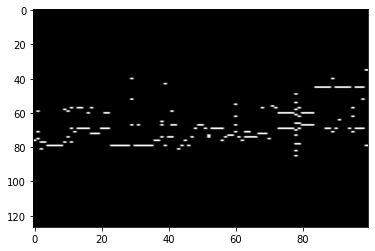

In [52]:
proll = pnotelist2proll(untransform_pnotelist(prediction_output)) * 96
img = proll2img(proll, show=True)

In [53]:
target_dir = '/content/drive/MyDrive/rnn-music-midis/'

In [54]:
proll2midi(proll).write(target_dir + str(len(os.listdir(target_dir))) + '.mid')

In [35]:
# model.save_weights("/content/drive/MyDrive/rnn-music-midis/layered-grus-models/models_30_epochs")